In [3]:
%pylab --no-import-all inline

from pymc3 import *
import theano.tensor as T
from numpy import random, sum as nsum, ones, concatenate, newaxis, dot, arange
import numpy as np

random.seed(1)

n_groups = 1
no_pergroup = 30
n_observed = no_pergroup * n_groups
n_group_predictors = 1
n_predictors = 3

group = concatenate([[i] * no_pergroup for i in range(n_groups)])
group_predictors = random.normal(size=(n_groups, n_group_predictors))  # random.normal(size = (n_groups, n_group_predictors))
predictors = random.normal(size=(n_observed, n_predictors))

group_effects_a = random.normal(size=(n_group_predictors, n_predictors))
effects_a = random.normal(
    size=(n_groups, n_predictors)) + dot(group_predictors, group_effects_a)

y = nsum(
    effects_a[group, :] * predictors, 1) + random.normal(size=(n_observed))


model = Model()
with model:

    # m_g ~ N(0, .1)
    group_effects = Normal(
        "group_effects", 0, .1, shape=(1, n_group_predictors, n_predictors))

    # sg ~ Uniform(.05, 10)
    sg = Uniform("sg", .0, 10, testval=2.)


    # m ~ N(mg * pg, sg)
    effects = Normal("effects",
                     sum(group_predictors[:, :, newaxis] *
                     group_effects, 1), sg ** -2,
                     shape=(n_groups, n_predictors))

    s = Uniform("s", .01, 10, shape=n_groups)

    g = T.constant(group)

    # y ~ Normal(m[g] * p, s)
    yd = Normal('y', sum(effects[g] * predictors, 1), s[g] ** -2, observed=y)

    #start = find_MAP()
    #h = find_hessian(start)
    

    #step = Metropolis()
    #step = Slice()
    step = NUTS()

Populating the interactive namespace from numpy and matplotlib


In [24]:
n_predictors

3

In [12]:
group

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [11]:
n_groups

1

In [16]:
import pymc3 as pm
pm.debug.eval_univariate?

In [18]:
model.free_RVs

[group_effects, sg, effects, s]

In [36]:
lp = lambda x, y: model.logp({'group_effects': [[[0, 0, 0]]], 'sg': x, 'effects':[[y, y, y]], 's': [.05]})
lp = np.vectorize(lp)

In [46]:
import seaborn as sns

<matplotlib.contour.QuadContourSet instance at 0x7ffe77d0ccf8>

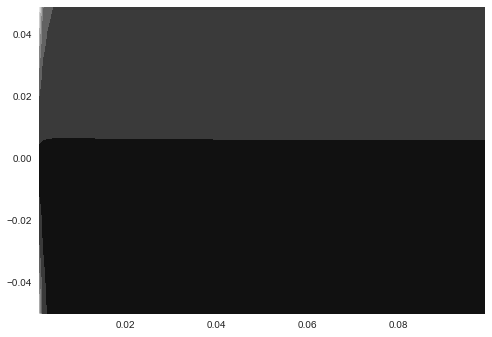

In [61]:
x, y = np.mgrid[0.001:0.1:.001, -.05:.05:.001]
plt.contourf(x, y, lp(x, y))

best of 3: 6.94 s per loop

In [6]:
%prun -q -D sample_nuts.prof sample(3e3, step, model=model)

 [-----------------100%-----------------] 3000 of 3000 complete in 74.1 sec 
*** Profile stats marshalled to file u'sample_nuts.prof'. 


In [4]:
%prun -q -D sample.prof sample(3e3, step, start, model=model)

 [-----------------100%-----------------] 3000 of 3000 complete in 80.0 sec 
*** Profile stats marshalled to file u'sample.prof'. 


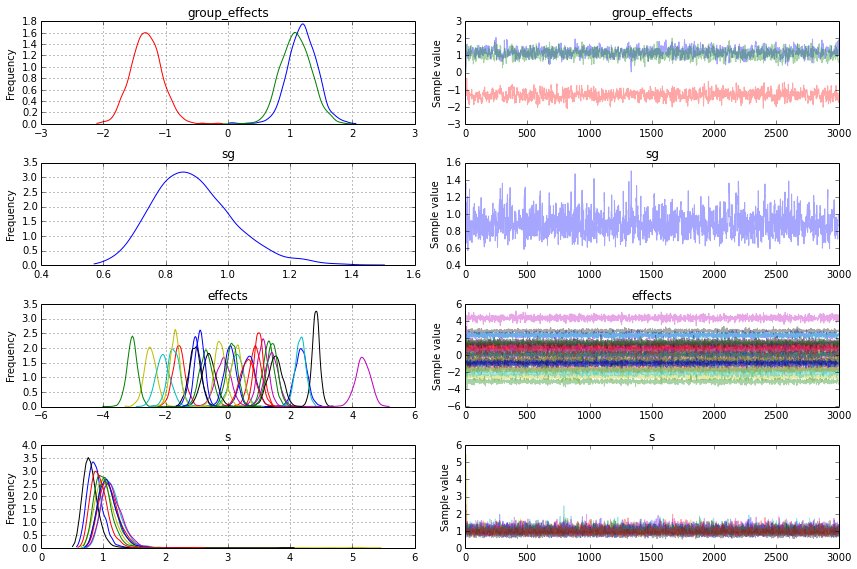

In [11]:
traceplot(trace);